#### Contents

In this notebook, we teach an agent how to play TikTakToe using a model free approach - Q Learning.
We define batchsize and batches in total to complete and let the agent play either against a random player as a base line, or against itself.

In [1]:
from tiktaktoe import *
from IPython.display import clear_output

In [2]:
# defining hyperparameters
reward_draw = 1
reward_win = 10
reward_lose = -20
epsilon = .7


total_batches = 100
batch_size = 1000

In [3]:
# reading stored qtable or creating a new one, comment out accordingly
import json

file_path = 'qtable_1727548713.json'

with open(file_path, 'r') as file:
    pass
    #q_table = json.load(file)

# uncomment this to create an empty qtable
q_table = dict()

In [4]:
#player_1 = RandomPlayer() # this is our opponent (in graphs, the lose rate is this players winrate)
player_1 = QPlayer(qtable=q_table, epsilon=epsilon)
player_2 = QPlayer(qtable=q_table, epsilon=epsilon) # this is 'us'

test_player = RandomPlayer()

In [5]:
def update_qtable(q_table, game_log, game_result):
    if game_result == 'draw': # draw results in +5 reward for everyone
        for log_entry in game_log:
            for tuple in q_table[log_entry[1]]:
                if tuple[0] == log_entry[2]:
                    index = next(i for i, tup in enumerate(q_table[log_entry[1]]) if tup[0] == tuple[0])

                    q_table[log_entry[1]][index] = (tuple[0], tuple[1] + reward_draw)
    else:
        if game_result == 'x_win': # reward actions by player 1. punish -1
            for log_entry in game_log:
                for tuple in q_table[log_entry[1]]:
                    if tuple[0] == log_entry[2]:
                        index = next(i for i, tup in enumerate(q_table[log_entry[1]]) if tup[0] == tuple[0])

                        if log_entry[0].value == -1:
                            q_table[log_entry[1]][index] = (tuple[0], tuple[1] + reward_lose)
                        if log_entry[0].value == 1:
                            q_table[log_entry[1]][index] = (tuple[0], tuple[1] + reward_win)
        
        if game_result == 'o_win': # reward actions by player -1. punish 1
            for log_entry in game_log:
                for tuple in q_table[log_entry[1]]:
                    if tuple[0] == log_entry[2]:
                        

                        index = next(i for i, tup in enumerate(q_table[log_entry[1]]) if tup[0] == tuple[0])

                        if log_entry[0].value == 1:
                            q_table[log_entry[1]][index] = (tuple[0], tuple[1] + reward_lose)
                        if log_entry[0].value == -1:
                            q_table[log_entry[1]][index] = (tuple[0], tuple[1] + reward_win)


Function to test agent after each completed batch during training

In [6]:
import random

test_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}

qplayer_wins_test = 0
random_wins_test = 0
draws_test = 0



def update_test_scores(result, qplayernr):
    global qplayer_wins_test, random_wins_test, draws_test
    if result == 'draw':
        draws_test += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins_test += 1
        if result == 'o_win':
            random_wins_test += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins_test += 1
        if result == 'x_win':
            random_wins_test += 1


def test(batch_nr):
    global qplayer_wins_test, random_wins_test, draws_test
    for _ in range(batch_size):
        if random.random() < .5: # coinflip who starts out
            game = TikTakToe(starting_player_x=test_player, second_player_o=player_2)
            while game.is_ongoing:
                test_player.take_field(game) # random player
                #player_1.take_field(game, game_log=game.game_log, change_epsilon=False)
                if not game.is_ongoing:
                    break
                player_2.take_field(game, game_log=game.game_log, change_epsilon=False)

            update_test_scores(game.result, qplayernr=PlayerNr.O)
            #update_qtable(q_table, game.game_log, game.result)
            game.reset()
        else:
            game = TikTakToe(starting_player_x=player_2, second_player_o=test_player)
            while game.is_ongoing:
                player_2.take_field(game, game_log=game.game_log, change_epsilon=False)
                if not game.is_ongoing:
                    break
                test_player.take_field(game) # random player
                #player_1.take_field(game, game_log=game.game_log, change_epsilon=False)

            update_test_scores(game.result, qplayernr=PlayerNr.X)
            #update_qtable(q_table, game.game_log, game.result)
            game.reset()

    
    test_results.append({'batch_nr': batch_nr, 'qplayer_wins': qplayer_wins_test, 'random_wins': random_wins_test, 'draws': draws_test})

    qplayer_wins_test = 0
    random_wins_test = 0
    draws_test = 0

# Train new qtable here. 

Do not run this cell if you want to try out a previously loaded qtable.
Go down to cell 12 instead.

In [7]:
batch_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}

import random
# training loop
qplayer_wins = 0
random_wins = 0
draws = 0



def update_scores(result, qplayernr):
    global qplayer_wins, random_wins, draws
    if result == 'draw':
        draws += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins += 1
        if result == 'o_win':
            random_wins += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins += 1
        if result == 'x_win':
            random_wins += 1
        


for batch in range(total_batches):
    for episode in range(batch_size):

        if random.random() < .5: # coinflip who starts out
            game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)
            while game.is_ongoing:
                player_1.take_field(game, game_log=game.game_log)
                if not game.is_ongoing:
                    break
                player_2.take_field(game, game_log=game.game_log)

            update_scores(game.result, qplayernr=PlayerNr.O)
            update_qtable(q_table, game.game_log, game.result)
            game.reset()
        else:
            game = TikTakToe(starting_player_x=player_2, second_player_o=player_1)
            while game.is_ongoing:
                player_2.take_field(game, game_log=game.game_log)
                if not game.is_ongoing:
                    break
                player_1.take_field(game, game_log=game.game_log)

            update_scores(game.result, qplayernr=PlayerNr.X)
            update_qtable(q_table, game.game_log, game.result)
            game.reset()

    
    batch_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins, 'random_wins': random_wins, 'draws': draws})
    print(f"Batch: {batch}/{total_batches}")

    test(batch)

    qplayer_wins = 0
    random_wins = 0
    draws = 0


# save trained qtable in json
import json
import time


# Generate a unique file name using a timestamp
timestamp = int(time.time())  # Current time in seconds
file_name = f"qtable_{timestamp}.json"

# Save the dictionary to a JSON file
with open(file_name, 'w') as json_file:
    json.dump(q_table, json_file, indent=4)

Batch: 0/100
Batch: 1/100
Batch: 2/100
Batch: 3/100
Batch: 4/100
Batch: 5/100
Batch: 6/100
Batch: 7/100
Batch: 8/100
Batch: 9/100
Batch: 10/100
Batch: 11/100
Batch: 12/100
Batch: 13/100
Batch: 14/100
Batch: 15/100
Batch: 16/100
Batch: 17/100
Batch: 18/100
Batch: 19/100
Batch: 20/100
Batch: 21/100
Batch: 22/100
Batch: 23/100
Batch: 24/100
Batch: 25/100
Batch: 26/100
Batch: 27/100
Batch: 28/100
Batch: 29/100
Batch: 30/100
Batch: 31/100
Batch: 32/100
Batch: 33/100
Batch: 34/100
Batch: 35/100
Batch: 36/100
Batch: 37/100
Batch: 38/100
Batch: 39/100
Batch: 40/100
Batch: 41/100
Batch: 42/100
Batch: 43/100
Batch: 44/100
Batch: 45/100
Batch: 46/100
Batch: 47/100
Batch: 48/100
Batch: 49/100
Batch: 50/100
Batch: 51/100
Batch: 52/100
Batch: 53/100
Batch: 54/100
Batch: 55/100
Batch: 56/100
Batch: 57/100
Batch: 58/100
Batch: 59/100
Batch: 60/100
Batch: 61/100
Batch: 62/100
Batch: 63/100
Batch: 64/100
Batch: 65/100
Batch: 66/100
Batch: 67/100
Batch: 68/100
Batch: 69/100
Batch: 70/100
Batch: 71/100
Ba

In [ ]:
test_results

In [ ]:
batch_results

# Try out the agent

In [ ]:
test_results = list() # stores dicts like this: {'batch_nr': x, 'qplayer_wins': y, 'draws': z, 'qplayer_loss': t}

import random
# training loop
qplayer_wins_test = 0
random_wins_test = 0
draws_test = 0

trials = 5


def update_scores(result, qplayernr):
    global qplayer_wins, random_wins, draws
    if result == 'draw':
        draws += 1
        return
    if qplayernr == PlayerNr.X:
        if result == 'x_win':
            qplayer_wins += 1
        if result == 'o_win':
            random_wins += 1
    if qplayernr == PlayerNr.O:
        if result == 'o_win':
            qplayer_wins += 1
        if result == 'x_win':
            random_wins += 1
        


for batch in range(trials):
    for episode in range(batch_size):

        if random.random() < .5: # coinflip who starts out
            game = TikTakToe(starting_player_x=player_1, second_player_o=player_2)
            while game.is_ongoing:
                player_1.take_field(game)
                if not game.is_ongoing:
                    break
                player_2.take_field(game, game_log=game.game_log, change_epsilon=False)

            update_scores(game.result, qplayernr=PlayerNr.O)
            #update_qtable(q_table, game.game_log, game.result)
            game.reset()
        else:
            game = TikTakToe(starting_player_x=player_2, second_player_o=player_1)
            while game.is_ongoing:
                player_2.take_field(game, game_log=game.game_log, change_epsilon=False)
                if not game.is_ongoing:
                    break
                player_1.take_field(game)

            update_scores(game.result, qplayernr=PlayerNr.X)
            #update_qtable(q_table, game.game_log, game.result)
            game.reset()

    
    test_results.append({'batch_nr': batch, 'qplayer_wins': qplayer_wins, 'random_wins': random_wins, 'draws': draws})
    print(f"Batch: {batch}/{trials}")

    qplayer_wins = 0
    random_wins = 0
    draws = 0

# PLOT

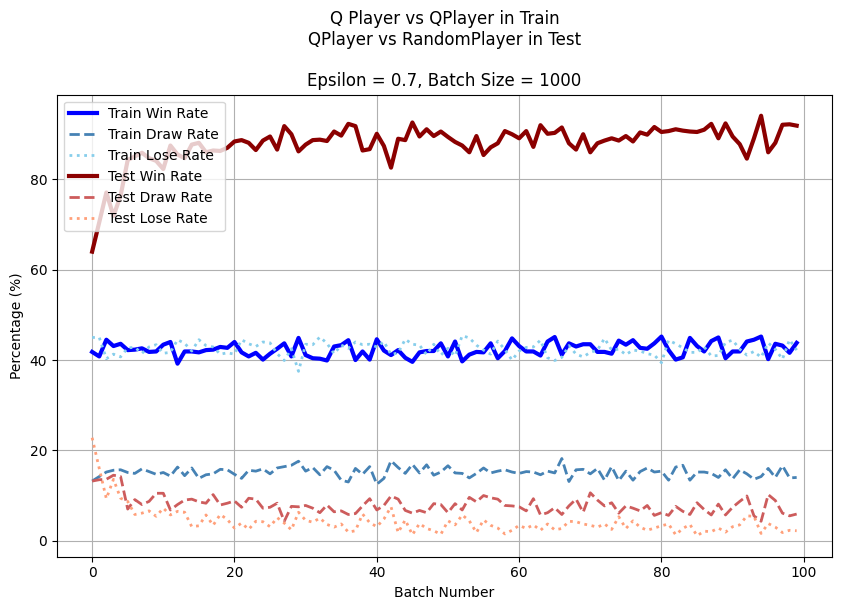

In [8]:
# this plot code is created with help from AI

import matplotlib.pyplot as plt

# Extracting batch numbers, win rates, lose rates, and draw rates for both train and test results
train_batch_nr = [entry['batch_nr'] for entry in batch_results]
test_batch_nr = [entry['batch_nr'] for entry in test_results]

def calculate_rates(results):
    qplayer_wins = [entry['qplayer_wins'] for entry in results]
    random_wins = [entry['random_wins'] for entry in results]
    draws = [entry['draws'] for entry in results]
    total_games = [q + r + d for q, r, d in zip(qplayer_wins, random_wins, draws)]
    
    win_rates = [q / total * 100 for q, total in zip(qplayer_wins, total_games)]
    lose_rates = [r / total * 100 for r, total in zip(random_wins, total_games)]
    draw_rates = [d / total * 100 for d, total in zip(draws, total_games)]
    
    return win_rates, lose_rates, draw_rates

# Calculate rates for train and test
train_win_rates, train_lose_rates, train_draw_rates = calculate_rates(batch_results)
test_win_rates, test_lose_rates, test_draw_rates = calculate_rates(test_results)



# Plotting
plt.figure(figsize=(10, 6))

# Define a new set of colors for each line
# Define new shades for each line (shades of blue for train, shades of red for test)
train_win_color = '#0000FF'  # Dark blue
train_draw_color = '#4682B4'  # Medium blue
train_lose_color = '#87CEEB'  # Light blue
test_win_color = '#8B0000'  # Dark red
test_draw_color = '#CD5C5C'  # Medium red
test_lose_color = '#FFA07A'  # Light red

# Train results (blue)
# Train results with different colors
plt.plot(train_batch_nr, train_win_rates, color=train_win_color, label="Train Win Rate", linewidth=3)  # Thick line
plt.plot(train_batch_nr, train_draw_rates, color=train_draw_color, label="Train Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(train_batch_nr, train_lose_rates, color=train_lose_color, label="Train Lose Rate", linestyle=':', linewidth=2)  # Dotted line

# Test results with different colors
plt.plot(test_batch_nr, test_win_rates, color=test_win_color, label="Test Win Rate", linewidth=3)  # Thick line
plt.plot(test_batch_nr, test_draw_rates, color=test_draw_color, label="Test Draw Rate", linestyle='--', linewidth=2)  # Dashed line
plt.plot(test_batch_nr, test_lose_rates, color=test_lose_color, label="Test Lose Rate", linestyle=':', linewidth=2)  # Dotted line


# Labels and title
plt.xlabel('Batch Number')
plt.ylabel('Percentage (%)')
# title with hyperparameters
plt.title(f'Q Player vs QPlayer in Train\nQPlayer vs RandomPlayer in Test\n\n'
          f'Epsilon = {epsilon}, Batch Size = {batch_size}')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()